** Setup relevant module imports **

For some reason, on the standard udacity-carnd ami, the opencv and moviepy installs end up on a different path than what the sys.path property is expecting. Hence i had to augment that property.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pylab
import glob
import random
import sys
sys.path.append('/usr/local/lib/python3.5/dist-packages')
import cv2
import moviepy

%matplotlib inline

** Generate objpoints and imgpoints using cv2.findChessboardCorners() **

Given a set of uncalibrated chessboard images of 9x6 corners, generate objpoints and imgpoints using cv2.findChessboardCorners(). Also draw uncalibrated/calibrated images for comparison.

number of uncalibrated images:  20
number of successfully calibrated images:  17


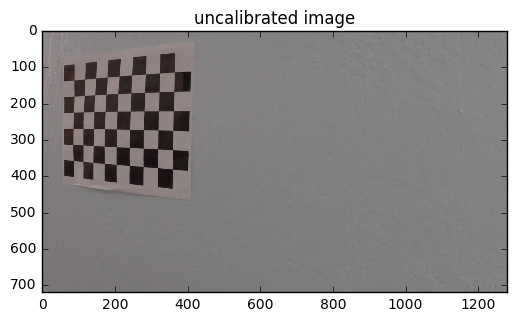

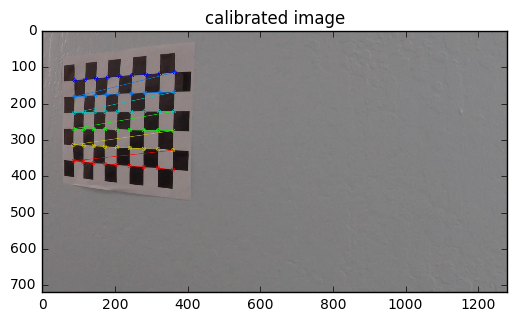

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('calibration_wide/calibration*.jpg')

# A temporary array to store index of images that were successfully calibrated.
# Not all images might get calibrated correctly.
calibrated = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        calibrated.append((idx,corners))
        
#  print some summaries
print('number of uncalibrated images: ',len(images))        
print('number of successfully calibrated images: ',len(calibrated))

# get a tuple for a calibrated image at random
random_idx,corners = random.choice(calibrated)  
# draw the uncalibrated image
random_uncalibrated_image = cv2.imread(images[random_idx])
plt.figure()
plt.title('uncalibrated image')
plt.imshow( random_uncalibrated_image)
#  Draw and display the corners using cv2.drawChessboardCorners()
calibrated_image_with_corners = cv2.drawChessboardCorners(
    random_uncalibrated_image, (9,6),corners, True)
plt.figure()
plt.title('calibrated image')
plt.imshow( calibrated_image_with_corners)

** Compute the mtx, dist using cv2.calibrateCamera() **

Using the imgpoints and objpoints above, compute the mtx, dist from cv2.calibrateCamera(). Also draw distorted/undistorted chessboard images for comparison.

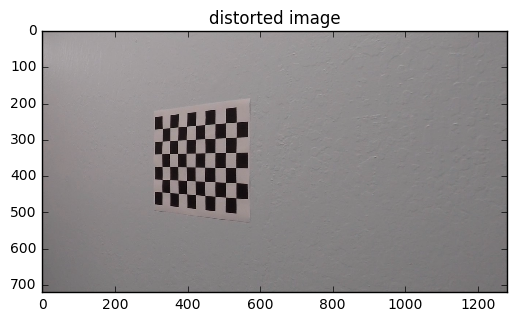

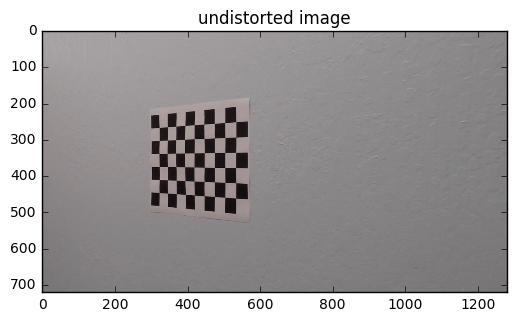

In [3]:
# Get a random distorted image
random_idx,corners = random.choice(calibrated)  
img = cv2.imread(images[random_idx])

# show the distorted image
plt.figure()
plt.title('distorted image')
plt.imshow( img)

# Do camera calibration given object points and image points
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# show the undistorted image
plt.figure()
plt.title('undistorted image')
plt.imshow( dst)


** Apply the distortion correction to any selected raw image. **

Draw distorted/undistorted images for a sample test image.

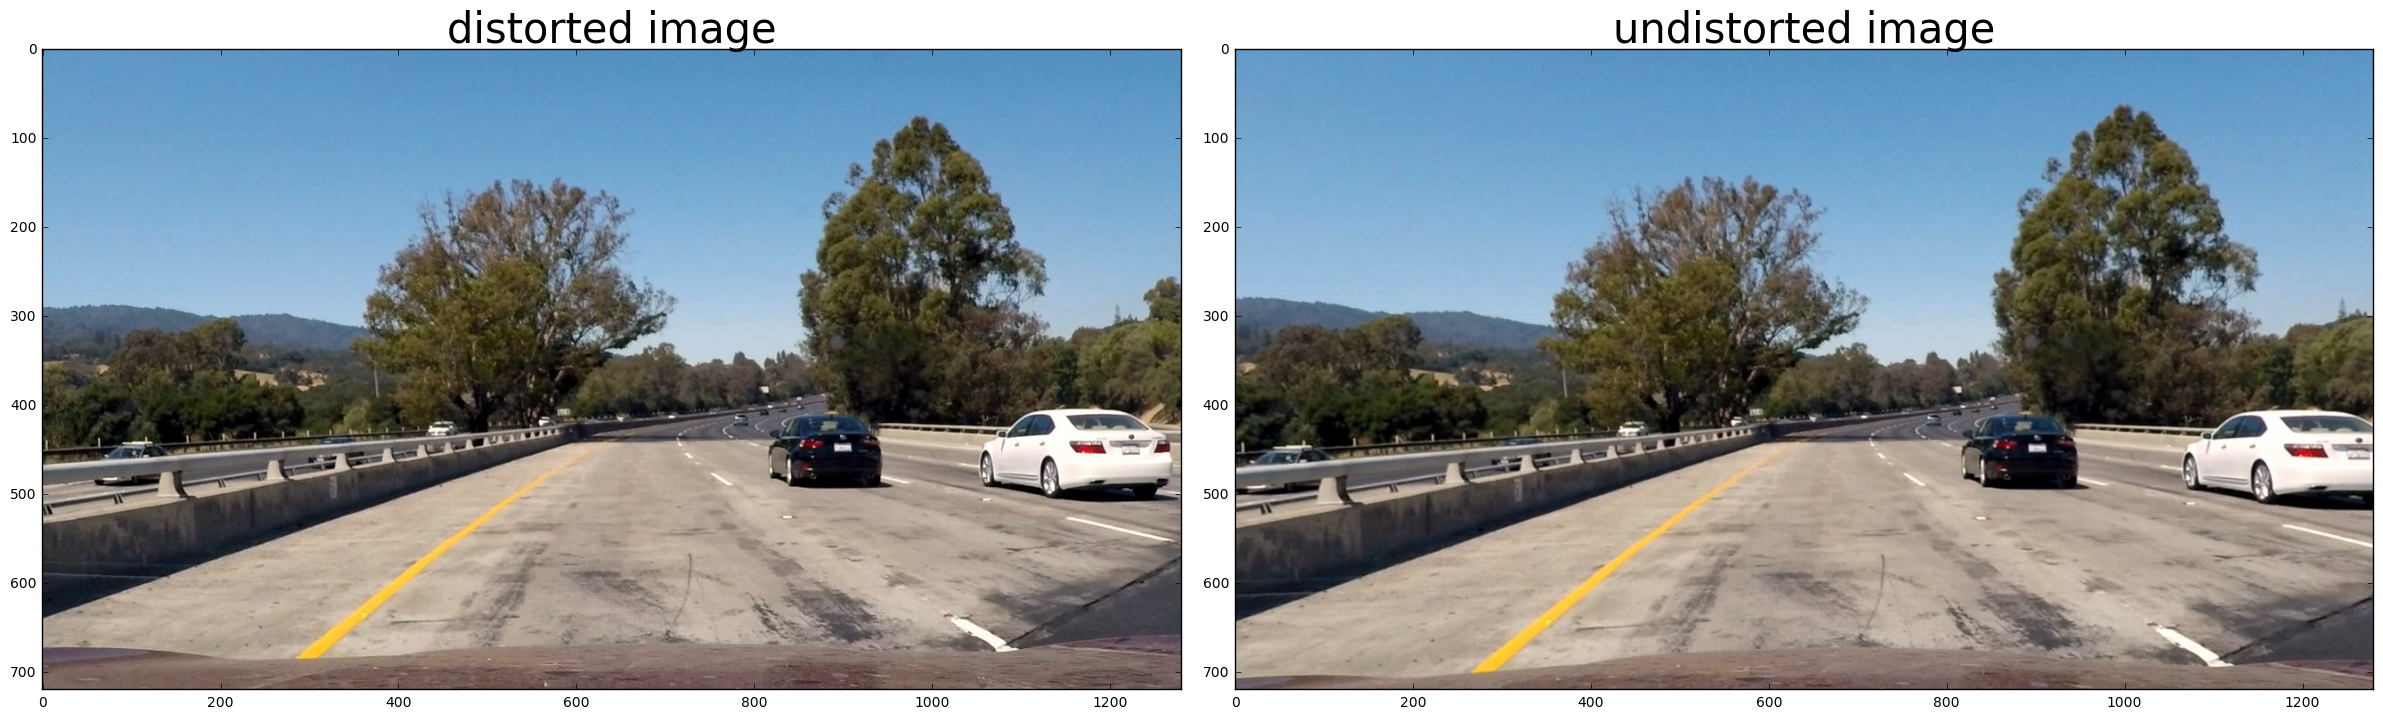

In [4]:
image = cv2.imread('test_images/test1.jpg')
# image = cv2.imread('test_images/testsnap.png')

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    return  cv2.undistort(img, objpoints, imgpoints)

undist = cal_undistort(image, mtx, dist)

# plot the two images
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.set_title('distorted image', fontsize=30)
ax1.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
ax2.set_title('undistorted image', fontsize=30)
ax2.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))


** Setup image preprocessing functions **

A set of preprocessing/color selection/color masking/ gradient filter functions that will be used in the main processing call.

In [5]:
def yellow_white_mask(img):
    # mask off everything except white and yellow
    lower_yw_bound = np.array([140, 140, 64])
    upper_yw_bound = np.array([255, 255, 255])
    mask = cv2.inRange(img, lower_yw_bound, upper_yw_bound)
    return cv2.bitwise_and(img, img, mask=mask)

def sobel_absolute_thresold(img, orient='x', sobel_kernel=5, thresh=(30, 150)):
    # Convert to grayscale
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:,:,2]
    # take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(v_channel, cv2.CV_64F,1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(v_channel, cv2.CV_64F,0, 1))
    # scale to 8-bit (0-255) then convert to type=uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
    return binary_output

def sobel_magnitude_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # derivates along x and y 
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output [(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def sobel_direction_gradient_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # derivates along x and y 
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # absolute values along x and y 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(dir_gradient)
    binary_output[(dir_gradient>=thresh[0])&(dir_gradient<=thresh[1])]=1
    return binary_output

def hls_s_channel_threshold(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s = hls[:,:,2]
    retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return s_binary

def hls_h_channel_threshold(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h = hls[:,:,0]
    retval, h_binary = cv2.threshold(h.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return h_binary

** Research generating a birds eye view transformed image **

Given the original undistorted color image, run the earlier pre-processing techniques to output the binary image and then plot the birds eye view transformed image from the binary output.

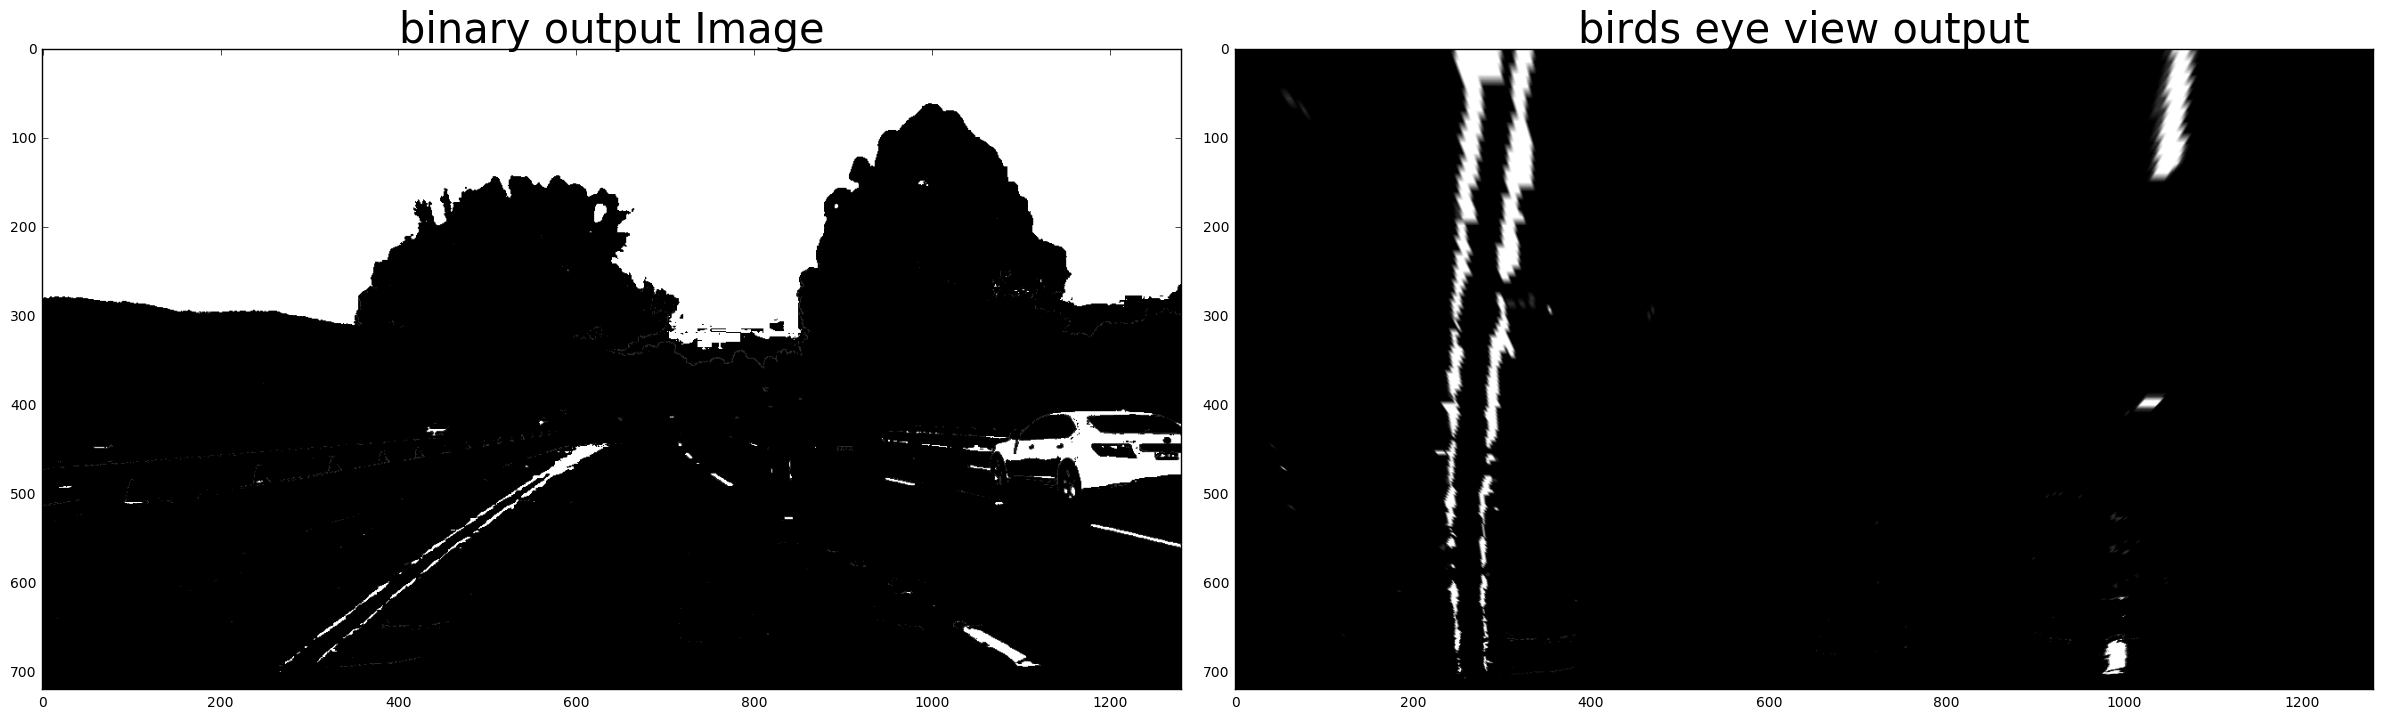

In [6]:
yellow_white = yellow_white_mask(undist)

gradx = sobel_absolute_thresold(yellow_white, orient='x', thresh=(25, 100))
grady = sobel_absolute_thresold(yellow_white, orient='y', thresh=(50, 150))
magch = sobel_magnitude_threshold(yellow_white, sobel_kernel=9, mag_thresh=(50, 250))
dirch = sobel_direction_gradient_threshold(yellow_white, sobel_kernel=15, thresh=(0.7, 1.3))

sch = hls_s_channel_threshold(yellow_white, thresh=(88, 190))
hch = hls_h_channel_threshold(yellow_white, thresh=(10, 20))

shadow = np.zeros_like(dirch).astype(np.uint8)
shadow[(sch > 0) & (hch > 0)] = 128
rEdgeDetect = ((yellow_white[:,:,1]/4)).astype(np.uint8)
rEdgeDetect = 255-rEdgeDetect
rEdgeDetect[(rEdgeDetect>210)] = 0

combined = np.zeros_like(dirch).astype(np.uint8)
combined[((gradx > 0) | (grady > 0) | ((magch > 0) & (dirch > 0)) | (sch > 0)) & 
         (shadow == 0) & (rEdgeDetect>0)] = 35
combined = np.maximum(combined,sch )

# select 4 source points for perspective transformation
# these values will vary somewhat based on initial raw image
src = np.float32([[220,719],[1220,719],[750,480],[550,480]])
# select 4 destination points for perspective transformation
dst = np.float32([[240,719],[1040,719],[1040,0],[240,0]])

M = cv2.getPerspectiveTransform(src, dst)
binary_birdseye = cv2.warpPerspective(combined, M, (1280, 720), flags=cv2.INTER_LINEAR)

# plot the result
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.set_title('binary output Image', fontsize = 30)
ax1.imshow(combined,cmap = "gray")
ax2.set_title('birds eye view output', fontsize=30)
ax2.imshow(binary_birdseye,cmap = "gray")


** Research various preprocessing techniques to find the right threshold parameters **

Apply different parameters and differing preprocessing functions to get a feel for the possible transformed images.

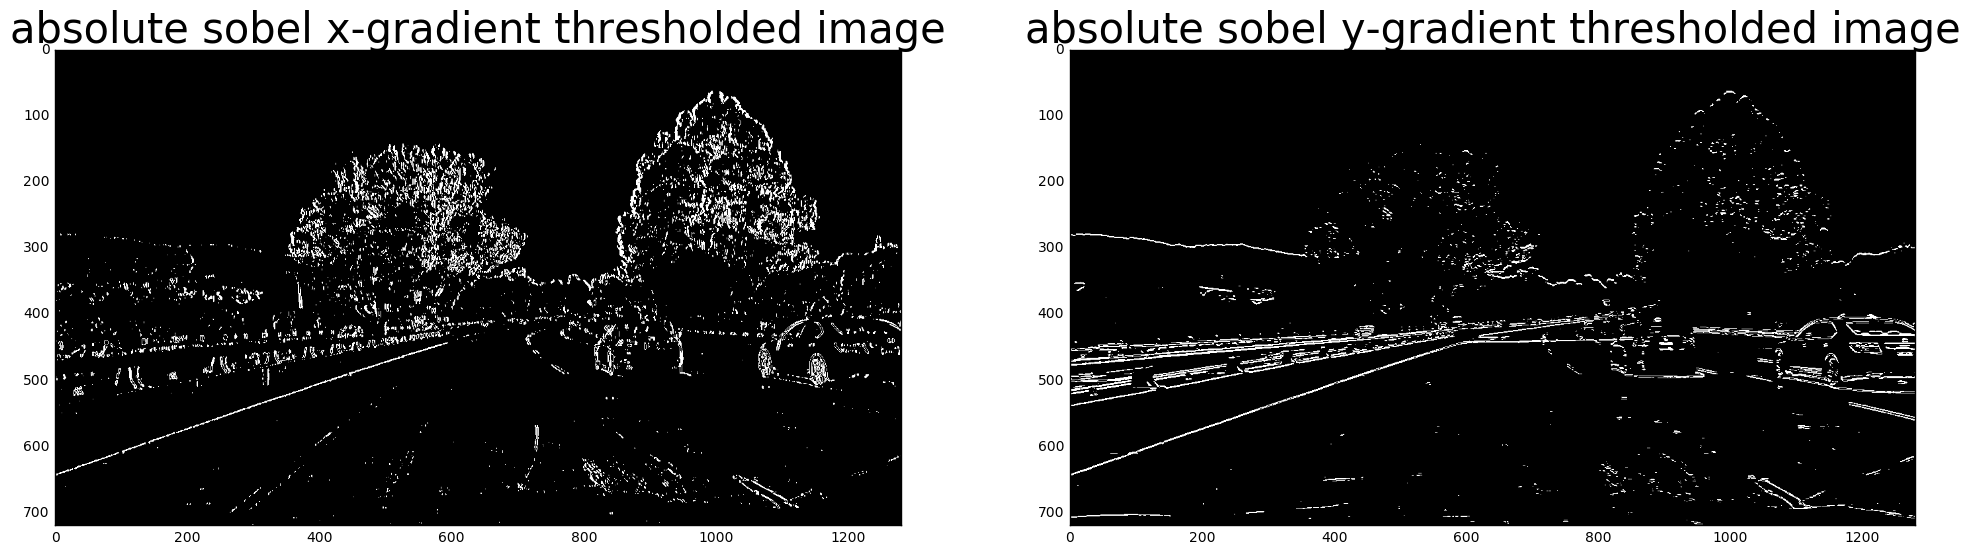

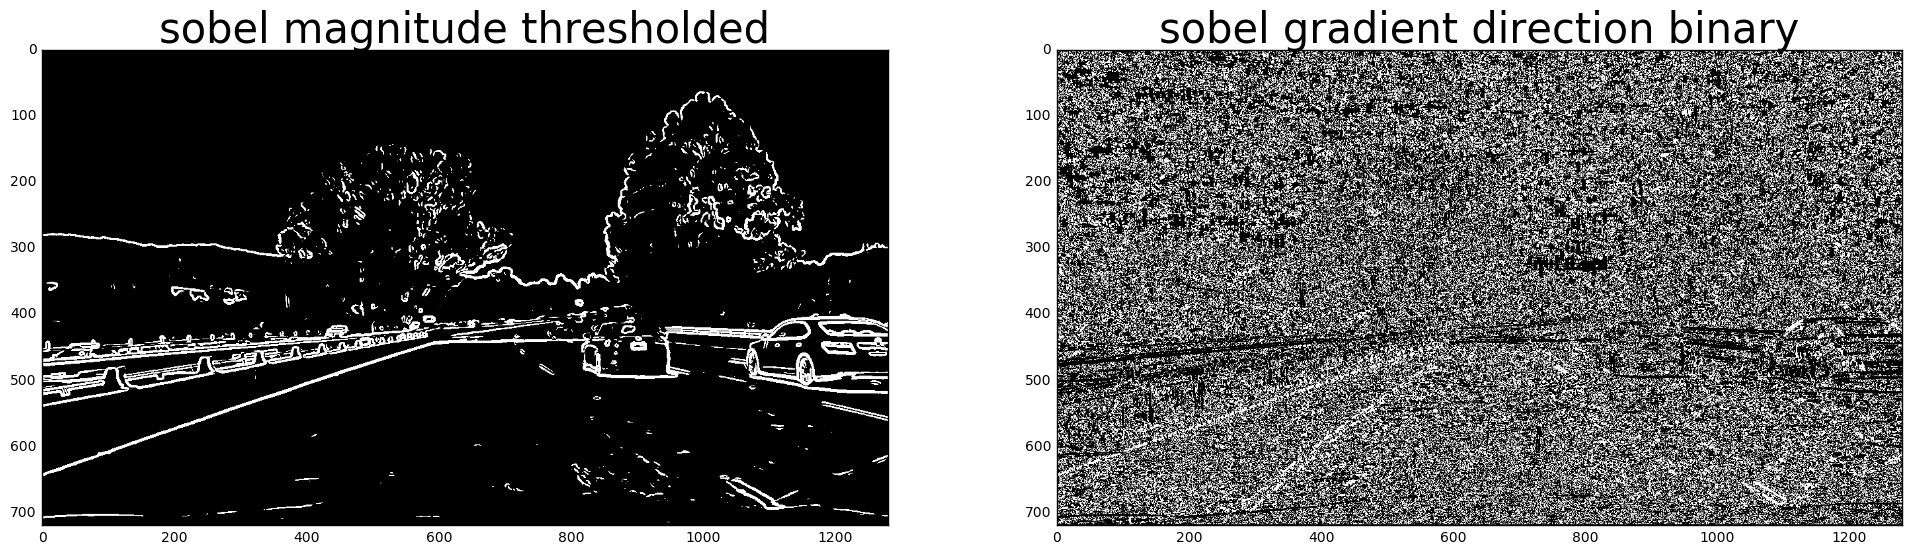

In [7]:
gradx = sobel_absolute_thresold(undist, orient='x', thresh=(25, 100))
grady = sobel_absolute_thresold(undist, orient='y', thresh=(50, 150))

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
ax1.set_title('absolute sobel x-gradient thresholded image', fontsize = 30)
ax1.imshow(gradx, cmap='gray')
ax2.set_title('absolute sobel y-gradient thresholded image', fontsize = 30)
ax2.imshow(grady, cmap='gray')

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
magch = sobel_magnitude_threshold(undist, sobel_kernel=9, mag_thresh=(50, 250))
ax1.set_title('sobel magnitude thresholded', fontsize = 30)
ax1.imshow(magch, cmap='gray')
dirch = sobel_direction_gradient_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3))
ax2.set_title('sobel gradient direction binary', fontsize = 30)
ax2.imshow(dirch, cmap='gray')


** Research how to identify lane-line pixels and fit their positions with a polynomial **

Given starting x-coordinates for the two lanes, use np.polyfit() to generate approximate quadratic polynomial fits to the data.

Coefficients for left  lane polynomial [  3.46793439e-04  -4.75508108e-01   3.61392763e+02]
Coefficients for right lane polynomial [  3.40061005e-04  -4.62161508e-01   1.05988755e+03]


(720, 0)

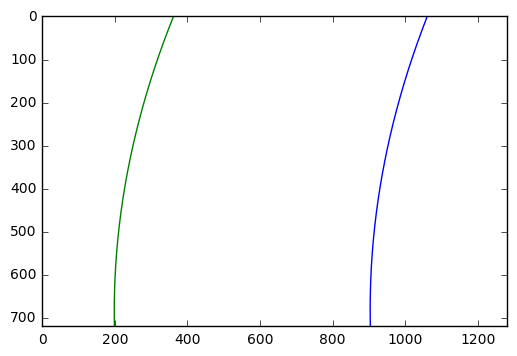

In [8]:
# dummy data for first previous lane
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])
leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
print('Coefficients for left  lane polynomial',left_fit)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
print('Coefficients for right lane polynomial',right_fit)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Generate x and y values for plotting
ploty = np.linspace(0, 719, num=720)

plt.plot(left_fitx, ploty, color='green')
plt.plot(right_fitx, ploty, color='blue')
plt.xlim(0, 1280)
plt.ylim(720, 0)


** Research how to generate a histogram , from the transformed birds eye binary image **

Also plot the histogram.

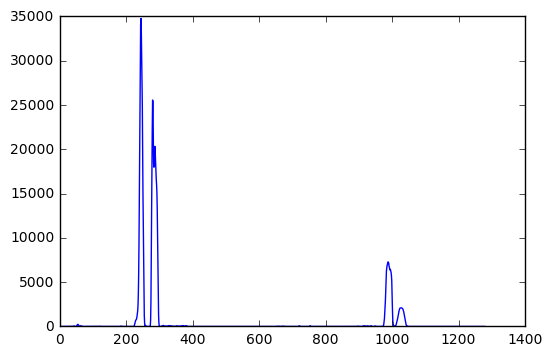

In [9]:
histogram = np.sum(binary_birdseye[binary_birdseye.shape[0]//2:,:], axis=0)
plt.plot(histogram)

** Research relevant polygons of interest from the image **

Also plot them on blank image and on the road

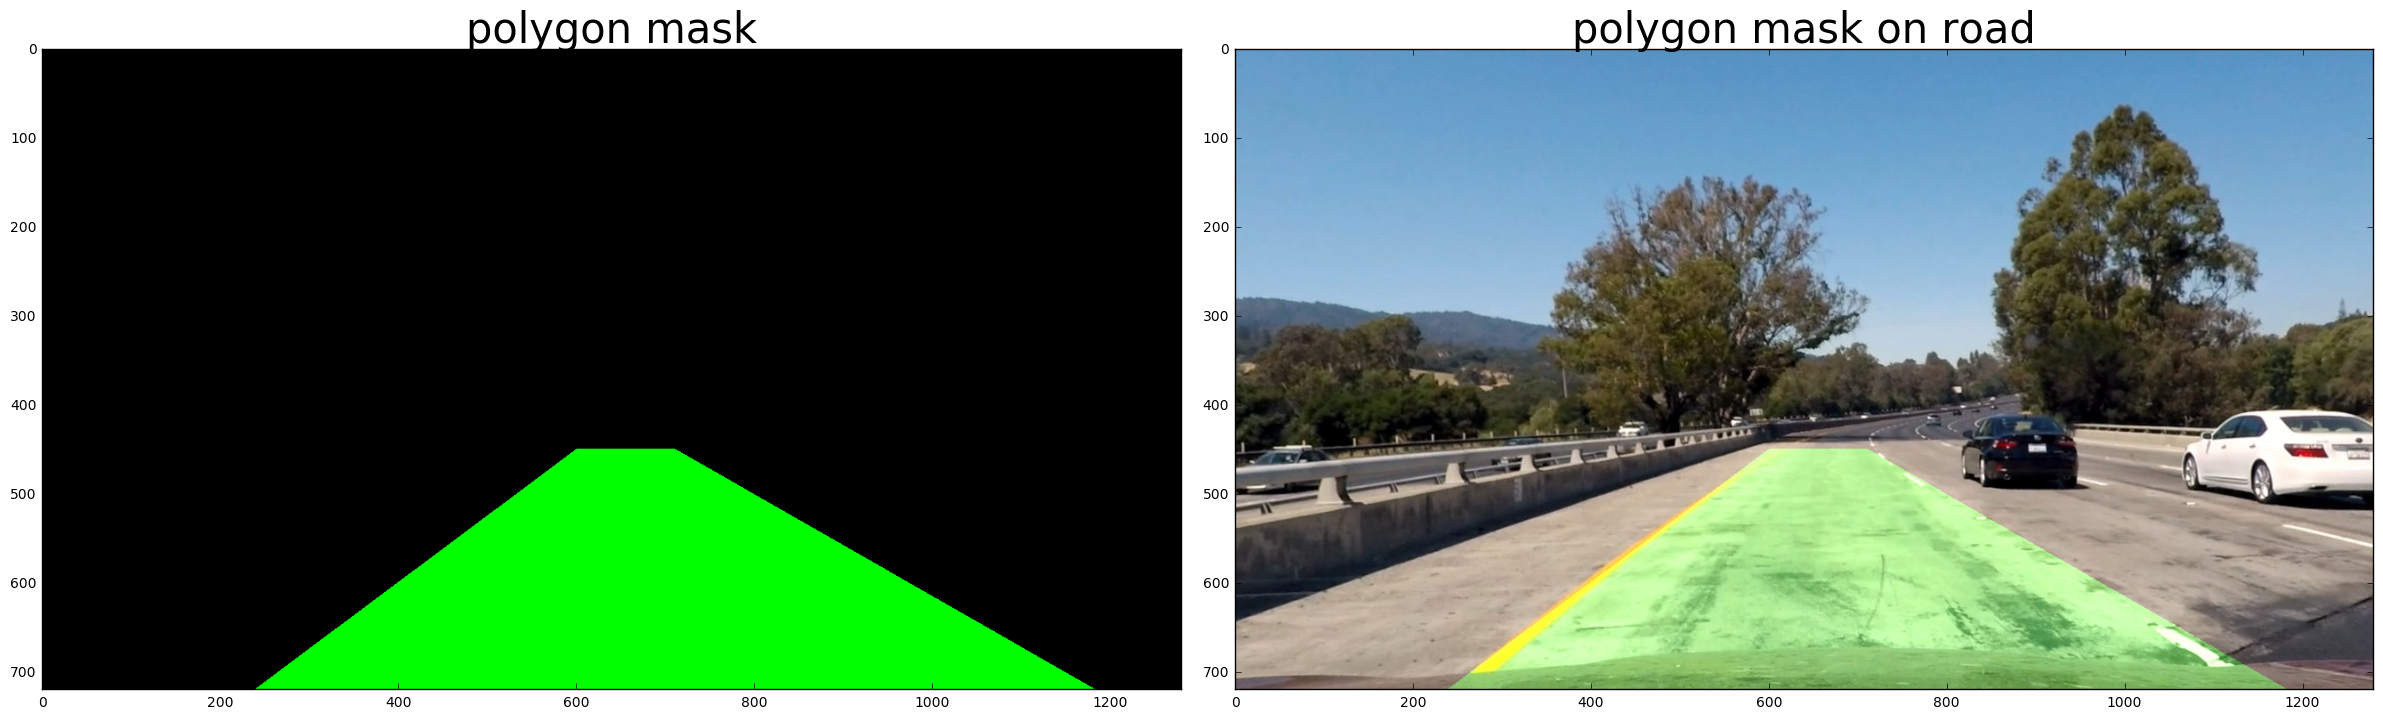

In [10]:
pts = np.array([[240,719],[600,450],[710,450],[1180,719]], np.int32)
pts = pts.reshape((-1,1,2))

polyshape = cv2.fillPoly(np.zeros_like(undist), np.int_([pts]), (0,255, 0))
polyshape_on_road = cv2.addWeighted(undist, 1, polyshape, 0.3, 0)

# plot the result
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.set_title('polygon mask', fontsize = 30)
ax1.imshow(cv2.cvtColor(polyshape,cv2.COLOR_BGR2RGB))
ax2.set_title('polygon mask on road', fontsize=30)
ax2.imshow(cv2.cvtColor(polyshape_on_road,cv2.COLOR_BGR2RGB))

** Setup classes that are useful for validating line characteristic **

The class is reusable and being used subsequently

In [11]:
# Attributes: 
#  detected: A boolean True/False value if lines are detected
 
class Line():
    def __init__(self):
        pass 
        
        
    def line_detect(self, array):
        # was the line detected in the last iteration?
        pixels = np.sum(array)
        if pixels < 3000:
            self.detected = False 
        else:
            self.detected = True
        
        
    def therest():
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #leftx for the last fit
        self.prior_leftx = None
        #lefty for the last fit
        self.prior_lefty = None
        #rightx for the last fit
        self.prior_rightx = None
        #righty for the last fit
        self.prior_righty = None

** Helper function to annotate an image **

Used with the main process_image() function below

In [12]:
def annotate_image(undist, binary_warped, Minv,
                   left_fit,right_fit,lefty,righty,leftx,rightx,
                  ym_per_pix,xm_per_pix):
    #left and right polyfits for curvature calculation
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    y_eval = 719

    #define curvature 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                     /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                        /np.absolute(2*right_fit_cr[0])
    
    # define center
    left_line_baseX = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_line_baseX = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    scale = 3.7/np.abs(left_line_baseX - right_line_baseX)
    midpoint = np.mean([left_line_baseX, right_line_baseX])
    offset = (1280/2 - midpoint) * scale

    # debug print
    # print('lefty',len(lefty),left_line_baseX,right_line_baseX,
    #   left_curverad,right_curverad)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #  Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty ]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    undist = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    veh_pos = img.shape[1]//2

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(undist, 'Radius of curvature (Left)  = %.2f m' % (left_curverad), (10, 40), font, 1,
        (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(undist, 'Radius of curvature (Right) = %.2f m' % (right_curverad), (10, 70), font, 1,
        (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(undist, 'Vehicle position : = %.2f m of center' % (offset), 
       (10, 100), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return undist

** Main driver for each processing each image **

Returns a suitably undistorted and annotated image

In [13]:
def process_image(image):
    
    global left_fit, right_fit, set_prev, ci_left_line,ci_right_line 
    
    undist = cal_undistort(image, mtx, dist)
    yellow_white = yellow_white_mask(undist)
    gradx = sobel_absolute_thresold(yellow_white, orient='x', thresh=(25, 100))
    grady = sobel_absolute_thresold(yellow_white, orient='y', thresh=(50, 150))
    magch = sobel_magnitude_threshold(yellow_white, sobel_kernel=9, mag_thresh=(50, 250))
    dirch = sobel_direction_gradient_threshold(yellow_white, sobel_kernel=15, thresh=(0.7, 1.3))
    sch = hls_s_channel_threshold(undist, thresh=(88, 190))
    hch = hls_h_channel_threshold(undist, thresh=(50, 100))
    shadow = np.zeros_like(dirch).astype(np.uint8)
    shadow[(sch > 0) & (hch > 0)] = 128
    rEdgeDetect = ((undist[:,:,1]/4)).astype(np.uint8)
    rEdgeDetect = 255-rEdgeDetect
    rEdgeDetect[(rEdgeDetect>210)] = 0
    combined = np.zeros_like(dirch).astype(np.uint8)
    combined[((gradx > 0) | (grady > 0) | ((magch > 0) & (dirch > 0)) | (sch > 0)) & 
         (shadow == 0) & (rEdgeDetect>0)] = 35
    combined = np.maximum(combined,sch )
    
    margin = 50
    
    # define 4 source points for perspective transformation
    src = np.float32([[220,719],[1220,719],[750,480],[550,480]])
    # define 4 destination points for perspective transformation
    dst = np.float32([[240,719],[1040,719],[1040,0],[240,0]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp an image using the perspective transform, M:
    binary_warped = cv2.warpPerspective(combined, M, (1280, 720), flags=cv2.INTER_LINEAR)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # number of sliding windows
    nwindows = 9
    # height of each sliding window
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Define conversions in x and y from pixels space to meters
    # meters per pixel in y dimension (denominator is similar to 719 -0)
    ym_per_pix = 30/720 
    # meteres per pixel in x dimension (denominator is similar to 1240-240)
    xm_per_pix = 3.7/800 
            
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    if set_prev == 0:
        set_prev = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        left_fit_tmp = np.polyfit(lefty, leftx, 2)
        left_line_baseX_tmp = left_fit_tmp[0]*720**2 + left_fit_tmp[1]*720 + left_fit_tmp[2]
        # Reset leftx bottom left to prior when its excessive.
        if (left_line_baseX_tmp) < 310 and (left_line_baseX_tmp) >= 200:
            ci_left_line.prior_leftx = leftx
            ci_left_line.prior_lefty = lefty            
        else:
            leftx = ci_left_line.prior_leftx if hasattr(ci_left_line ,'prior_leftx') else leftx
            lefty = ci_left_line.prior_lefty if hasattr(ci_left_line ,'prior_lefty') else lefty
        # it was found by trial and error that when 
        # len(nonzerox[right_lane_inds]) < 400, the effective radius of
        # curvature starts to approach millions of kms. So for those
        # cases we just use the last derived values.
        if len(nonzerox[right_lane_inds]) > 400:
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 
            ci_right_line.prior_rightx = rightx
            ci_right_line.prior_righty = righty
        else:
            rightx = ci_right_line.prior_rightx
            righty = ci_right_line.prior_righty
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ci_left_line.current_fit = left_fit
        ci_right_line.current_fit = right_fit

        undist = annotate_image(undist, binary_warped, Minv,
            left_fit,right_fit,lefty,righty,leftx,rightx,ym_per_pix,xm_per_pix)
         
    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_fit = ci_left_line.current_fit 
        right_fit = ci_right_line.current_fit 
        
        # left_fit[] and right_fit[] are global from the if statement first time
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
            left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy 
            + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        left_fit_tmp = np.polyfit(lefty, leftx, 2)
        left_line_baseX_tmp = left_fit_tmp[0]*720**2 + left_fit_tmp[1]*720 + left_fit_tmp[2]
        if (left_line_baseX_tmp) < 310 and (left_line_baseX_tmp) >= 200:
            ci_left_line.prior_leftx = leftx
            ci_left_line.prior_lefty = lefty            
        else:
            leftx = ci_left_line.prior_leftx if hasattr(ci_left_line ,'prior_leftx') else leftx
            lefty = ci_left_line.prior_lefty if hasattr(ci_left_line ,'prior_lefty') else lefty
        if len(nonzerox[right_lane_inds]) > 400:
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 
            ci_right_line.prior_rightx = rightx
            ci_right_line.prior_righty = righty
        else:
            rightx = ci_right_line.prior_rightx
            righty = ci_right_line.prior_righty

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        undist = annotate_image(undist, binary_warped,Minv,
            left_fit,right_fit,lefty,righty,leftx,rightx,ym_per_pix,xm_per_pix)
    
    return undist

** Main driver for displaying a sequence of undistorted images **

Displays a sequence of images, given a set of suitably undistorted and annoted images from the prior process_image() function.

In [14]:
def show_images(images, per_row=1, titles=None, main_title=None):
    figure = plt.figure(1)

    for n, img in enumerate(images):
        ax = figure.add_subplot(np.ceil(len(images) / per_row), per_row, n + 1)

        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        if (titles is not None and len(titles) >= n):
            ax.set_title(titles[n])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        plt.imshow(img)
    if main_title is not None:
        plt.suptitle(main_title)

    plt.show()  

** Generate and Visualise some sample undistorted and annotated images **

Given a set of distorted raw images, randomly select a few and run them through process_image() and show_images() functions written earlier

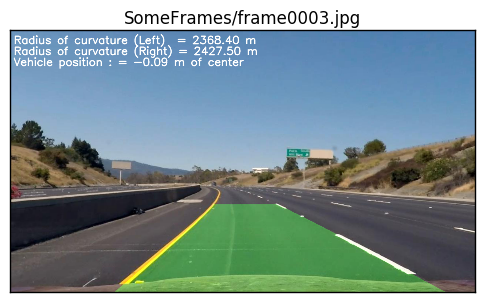

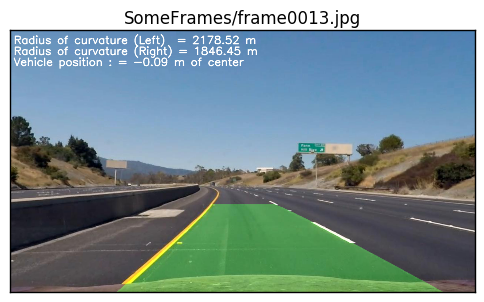

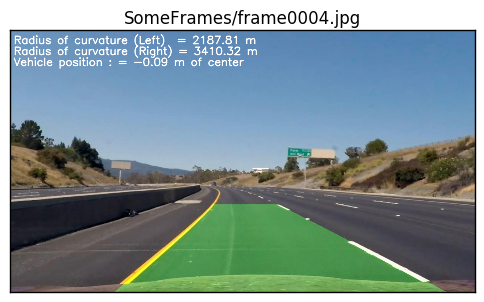

In [15]:
# this variable is for the initial frame one 
set_prev = 0
# create lane line objects for left and right
ci_left_line = Line()
ci_right_line = Line()

images_path = 'SomeFrames/*.jpg'
image_files = glob.glob(images_path)

# only show a sample of images overlaid with the highlighted area
random_images = random.sample(image_files,3)
for fname in random_images:
     
    img = cv2.imread(fname)
    show_images([process_image(img)], titles=[fname])  

** Run the image processing pipeline over a raw video feed **

Use the image processing pipeline above to cycle through a raw video feed

In [16]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip#*
from IPython.display import HTML

movie_output = 'movie.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(30)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(movie_output, audio=False)
# ipython_display(VideoFileClip(movie_output))


[MoviePy] >>>> Building video movie.mp4
[MoviePy] Writing video movie.mp4


100%|█████████▉| 1260/1261 [06:22<00:00,  3.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie.mp4 

CPU times: user 6min 53s, sys: 1.72 s, total: 6min 55s
Wall time: 6min 25s
